# Constants

In [1]:
IALAB_USER = 'jiossandon'

# Imports

In [2]:
import os
import os.path as osp
import json
import sys

In [3]:
matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'

In [4]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [5]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

# Simulator

In [6]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading

    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [7]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

## Initialize data for after processing

In [8]:
from collections import defaultdict

viewpoints_information = defaultdict(dict)

# Visualization

In [9]:
LABEL_MAPPING = {
    'a': 'bathroom',
    'b': 'bedroom',
    'c': 'closet',
    'd': 'dining room',
    'e': 'entryway/foyer/lobby',
    'f': 'familyroom',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundryroom/mudroom',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'meetingroom/conferenceroom',
    'n': 'lounge',
    'o': 'office',
    'p': 'porch/terrace/deck/driveway',
    'r': 'rec/game',
    's': 'stairs',
    't': 'toilet',
    'u': 'utilityroom/toolroom',
    'v': 'tv',
    'w': 'workout/gym/exercise',
    'x': 'outdoor areas containing grass, plants, bushes, trees, etc.',
    'y': 'balcony',
    'z': 'other room',
    'B': 'bar',
    'C': 'classroom',
    'D': 'dining booth',
    'S': 'spa/sauna',
    'Z': 'junk',
    '-': 'no label'
}

def get_viewpoint_region_name(metadata, viewpoint):
    values = metadata.get_region(viewpoint).label.values
    if not values.size > 0:
        return 'no label'
    label_keyword = values[0]
    return LABEL_MAPPING[label_keyword]

In [10]:
import matplotlib.patches as patches

IMG_HEIGHT = 1440
IMG_WIDTH = 2880

def get_info(scan, viewpoint, viewpoint_heading, next_viewpoint, metadata, viewpoints_information, visualize=True):
    objects = metadata.angle_relative_viewpoint_objects(viewpoint)
    
    # Add to post processing data
    viewpoints_information[viewpoint]['objects'] = []
    viewpoints_information[viewpoint]['viewpoints'] = []

    connectivity_path = f'/home/{IALAB_USER}/repos/360-visualization/connectivity/{scan}_connectivity.json'
    reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path)
    
    if visualize:
        images = []
        for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
            im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
            images.append(im)

        fig, ax = plt.subplots(1,1, figsize=(18,9))

        img = np.concatenate(images[::-1], axis=0)

        ax.imshow(img)
        plt.xticks(np.linspace(0, IMG_WIDTH - 1, 5), [-180, -90, 0, 90, 180])
        plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
        plt.yticks(np.linspace(0, IMG_HEIGHT - 1, 5), [-180, -90, 0, 90, 180])
    
    next_heading = viewpoint_heading
    x0, y0 = viewpoint_heading, 0
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name
        
        if any(word in category for word in ['floor', 'ceiling', 'unknown', 'wall', 'door', 'rug', 'otherroom']):
            continue

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
        
        CONST = 300 * 1/obj.distance * 3
        
        # Add to post processing data
        viewpoints_information[viewpoint]['objects'].append(
            [
                category, 
                first_coord / IMG_WIDTH * 2 * np.pi,
                obj.distance,
                (obj.r0, obj.r1, obj.r2),
                float(obj.r1) * CONST * float(obj.r0) * CONST
            ]
        )
        
        if visualize:
            first_pos = first_coord - float(obj.r1) * CONST / 2
            second_pos = second_coord - float(obj.r0) * CONST / 2
            rect = patches.Rectangle((first_pos, second_pos), float(obj.r1) * CONST, float(obj.r0) * CONST, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(first_coord, second_coord, f'{category}', color='white', backgroundcolor='black')


    for reachable_viewpoint in reachable_viewpoints.itertuples():
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)
        
        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
                
        if reachable_viewpoint.name == next_viewpoint:
            next_heading += heading
            
            if visualize:
                ax.arrow(first_coord, second_coord + 150, 0, -50, width=20, color='green')
        
        region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)
        
        # Add to post processing data
        viewpoints_information[viewpoint]['viewpoints'].append(
            [region_name_of_viewpoint, 
             first_coord / IMG_WIDTH * 2 * np.pi]
        )
        
        if visualize:
            ax.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='black')
            ax.plot(first_coord, second_coord, color='blue', marker='o', 
                     markersize= 15 / reachable_viewpoint.distance, linewidth=1)

        
    return next_heading

In [11]:
plt.close('all')

### Define the instruction to overview

In [12]:
instructions_path = f'/home/{IALAB_USER}/repos/objects-auxiliary/paths/R2R_val_unseen.json'

# Search by path id first. If it doesnt exist, then search by instruction index.
instruction_index = 68
path_id = 6576

In [13]:
instruction_data = {}
with open(instructions_path, 'r') as f:
    data = json.load(f)
    print(f"The file contain {len(data)} paths. The index must be between 0 and {len(data) - 1}.")
    for elem in data:
        if int(elem['path_id']) == path_id:
            print("Yep, found by path id")
            instruction_data = elem
    if instruction_data == {}:
        instruction_data = data[instruction_index]
    
scan = instruction_data['scan']
viewpoints_sequence = instruction_data['path']
initial_heading = instruction_data['heading']

The file contain 783 paths. The index must be between 0 and 782.
Yep, found by path id


### Set the metadata and cell display

In [14]:
metadata = metadata = HouseSegmentationFile.load_mapping(scan)
print("Press 'Shift + O' on Jupyter Notebook for avoid cell collapse")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) # Bigger height of the cell output

Cached file exists, loading.
Press 'Shift + O' on Jupyter Notebook for avoid cell collapse


### Plot viewpoints and save the data

- Exit the craft room and make a left. Go past the stairs that go downstairs and head towards the front door. Enter the formal living room and then pass into the dining room. Stop just before reaching the table and wait. 

- Walk past the stairs that go up. Go into the dining room and stop next to the glass dining table. 

- Exit the room. Turn left. Go straight until you pass the stairs. Pass the two first chairs one on each side and then turn right. Wait near the glass table with the white chairs. 


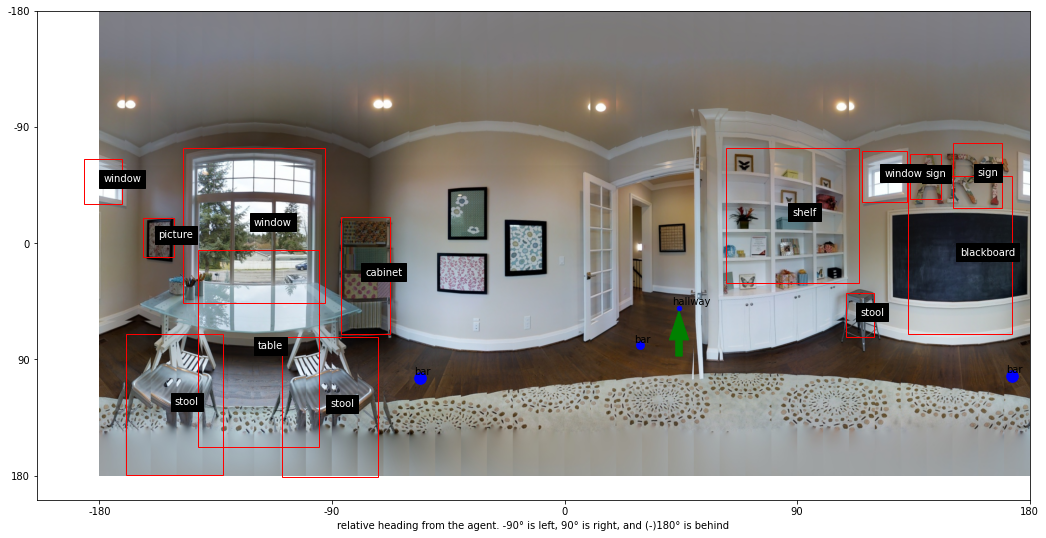

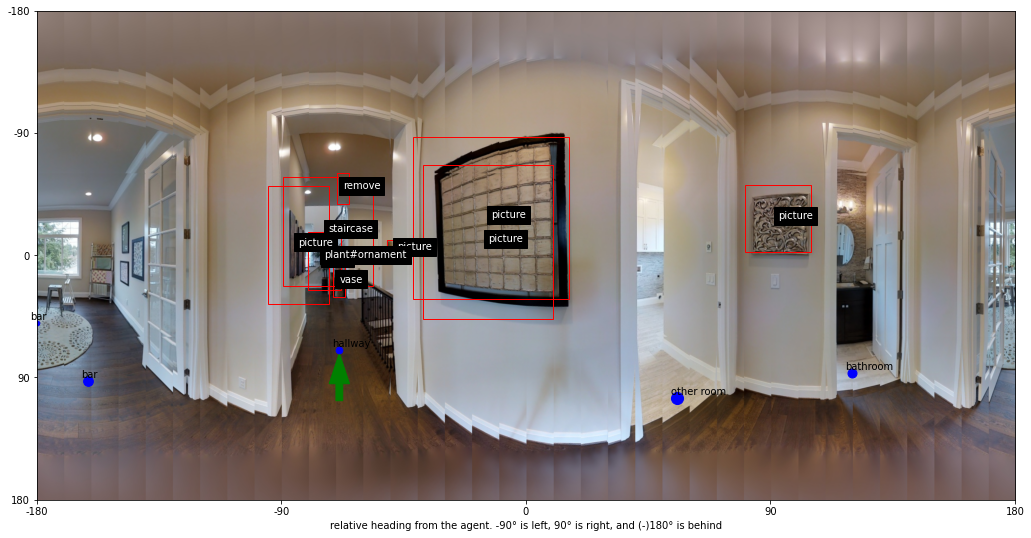

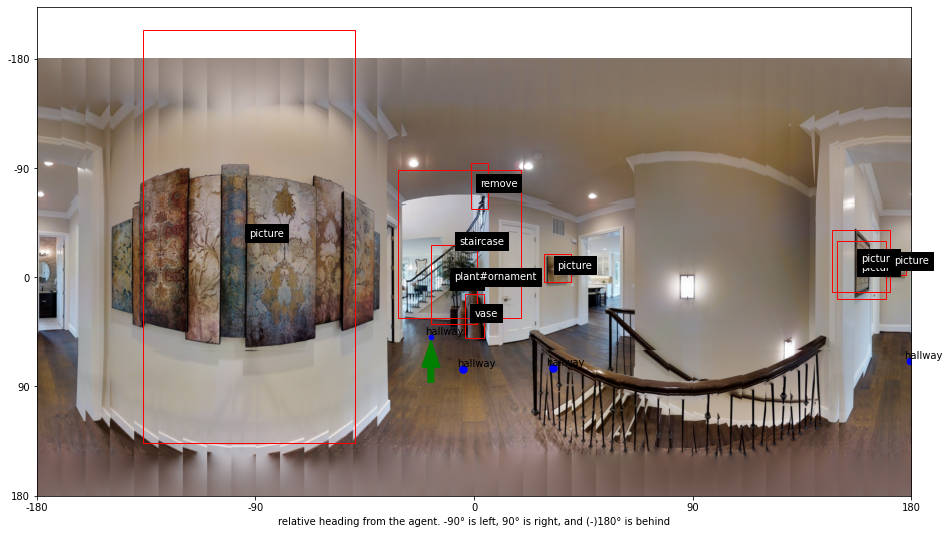

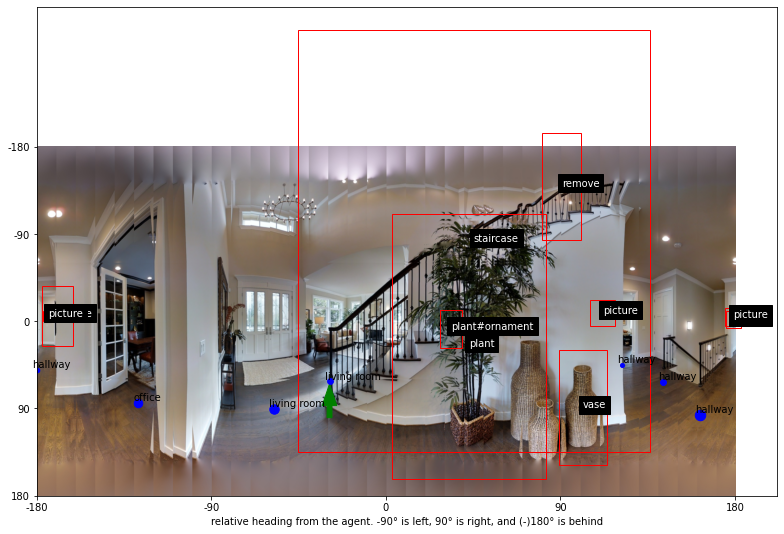

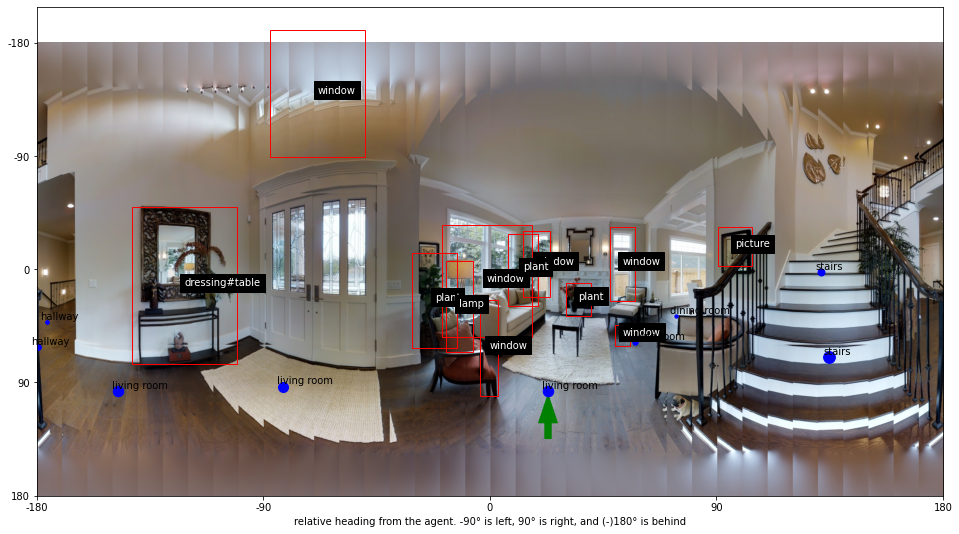

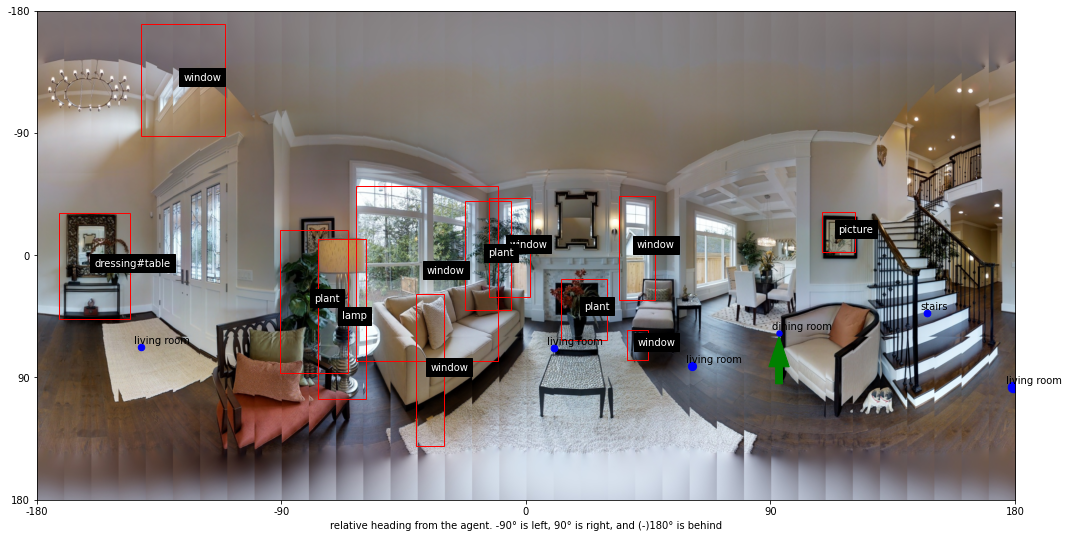

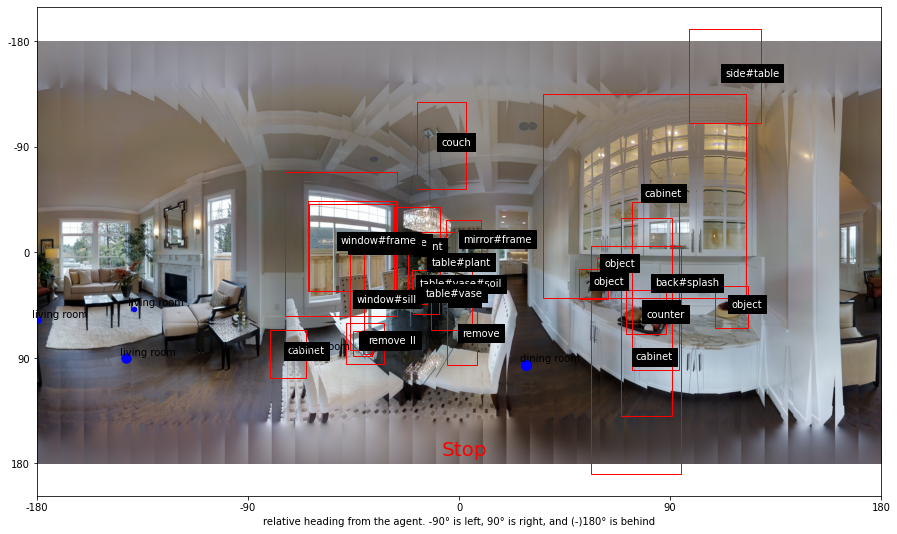

In [15]:
# Instructions
instructions = "- " + "\n\n- ".join(instruction_data['instructions'])
print(instructions)

heading = initial_heading
for idx, viewpoint in enumerate(viewpoints_sequence):
    if idx < len(viewpoints_sequence) - 1:
        heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information)
    else:
        heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information)
        plt.text(2880 // 2 - 60, 1440 - 30, 'Stop', fontsize=20, color='r') # Stop

## Objects presence on instructions

In [16]:
!pip install spacy

!python -m spacy download en_core_web_sm

You should consider upgrading via the '/home/jiossandon/repos/360-visualization/r2r/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 13.6 MB 204 kB/s eta 0:00:01


You should consider upgrading via the '/home/jiossandon/repos/360-visualization/r2r/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
import numpy as np

def get_reference(heading):
    pi = np.pi
    if pi/2 <= heading < (pi - 1/2):
        return 'left'
    elif (pi - 1/2) <= heading <= (pi + 1/2):
        return 'front'
    elif (pi + 1/2) < heading < 3 * pi/2:
        return 'right'
    else:
        return 'behind'
    
FORBIDDEN_WORDS = ['wall', 'unknown', 'floor', 'ceiling', 'light']
def used_data(instruction_nouns, objects, viewpoints, current_region):
    used_objects = []
    used_viewpoints = []
    for idx, noun in enumerate(instruction_nouns):
        percentage = round((idx + 1) / len(instruction_nouns) * 100, 2)
        
        for obj in objects:
            name, heading, distance, radius, area = obj
            if name in FORBIDDEN_WORDS:
                continue
            if noun in name.split("#"):
                used_objects.append([percentage, name, heading, get_reference(heading), distance, radius, area])
        for viewpoint in viewpoints:
            name, heading = viewpoint
            if noun in name.split("#"):
                if name != current_region:
                    used_viewpoints.append([percentage, name, heading, get_reference(heading)])
                else:
                    used_viewpoints.append([percentage, name, heading, 'current and ' + get_reference(heading)])
    return used_objects, used_viewpoints            
    
def all_data(index, objects, viewpoints, current_region):
    all_objects = []
    all_viewpoints = []

    for obj in objects:
        name, heading, distance, radius, area = obj
        if name in FORBIDDEN_WORDS:
            continue
        all_objects.append([index, name, heading, get_reference(heading), distance, radius, area])
    for viewpoint in viewpoints:
        name, heading = viewpoint
        if name != current_region:
            all_viewpoints.append([index, name, heading, get_reference(heading)])
        else:
            all_viewpoints.append([index, name, heading, 'current and ' + get_reference(heading)])
    return all_objects, all_viewpoints    

In [18]:
import spacy

nlp = spacy.load("en_core_web_sm")


def get_instructions_metadata(scan, instructions, initial_heading, viewpoints_sequence):
    metadata = HouseSegmentationFile.load_mapping(scan, log=False)
    viewpoints_information = defaultdict(dict)

    heading = initial_heading
    for idx, viewpoint in enumerate(viewpoints_sequence):
        if idx < len(viewpoints_sequence) - 1:
            heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information, visualize = False)
        else:
            heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information, visualize = False)
        
    total_viewpoints = len(viewpoints_sequence)
    instructions_elements = []
    for instruction in instructions:
        some_object_in_instruction = False
        elements = []
        # doc = nlp(instruction)

        # Nouns only
        # instruction_nouns = [token.text for token in doc if token.pos_ == "NOUN"]

        # All
        instruction_nouns = [token for token in instruction.split()]

        # Agent navigation for each node
        for index, viewpoint in enumerate(viewpoints_sequence):
            current_region = get_viewpoint_region_name(metadata, viewpoint)

            viewpoint_info = viewpoints_information[viewpoint]
            
            summary_data = all_data(
                index,
                viewpoint_info['objects'], 
                viewpoint_info['viewpoints'],
                current_region
            )
                        
            percentage = round((index + 1)/len(viewpoints_sequence) * 100, 2)
            
            objects_data, viewpoints_data = summary_data
            for element in objects_data:
                if element[1] in instruction.split():
                    some_object_in_instruction = True
                
                elements.append({
                    'name': element[1],
                    'sequence_index': element[0],
                    'sequence_len': len(viewpoints_sequence),
                    'path_percentage': percentage,
                    'heading': element[2],
                    'relative_position': element[3],
                    'distance': element[4],
                    'radius': element[5],
                    'area': element[6]
                })
            for element in viewpoints_data:
                elements.append({
                    'name': element[1],
                    'sequence_index': element[0],
                    'sequence_len': len(viewpoints_sequence),
                    'path_percentage': percentage,
                    'heading': element[2],
                    'relative_position': element[3]
                })
                
        if some_object_in_instruction:
            instructions_elements.append({
                'instruction': instruction,
                'elements': elements
            })
    return instructions_elements

### Save metadata

In [19]:
instructions_path = f'/home/{IALAB_USER}/repos/objects-auxiliary/paths/R2R_val_unseen.json'

In [20]:
from tqdm.notebook import tqdm

with open(instructions_path, 'r') as f:
    data = json.load(f)

new_instructions = []
acc_metadata = {}
for i in tqdm(range(len(data))):
    # Comment this for running
    
    instruction_data = data[i]

    scan = instruction_data['scan']
    path_id = instruction_data['path_id']
    initial_heading = instruction_data['heading']
    instructions = instruction_data['instructions']
    viewpoints_sequence = instruction_data['path']
    instructions_metadata = get_instructions_metadata(scan, instructions, initial_heading, viewpoints_sequence)
    if instructions_metadata:
        acc_metadata[path_id] = {
            'scan': scan,
            'initial_heading': initial_heading,
            'instructions': instructions,
            'viewpoints_sequence': viewpoints_sequence,
            'instructions_metadata': instructions_metadata
        }
        
    instruction_data['instructions'] = instruction_metadata.map(lambda elem: elem['instruction'])
    new_instructions.append(instruction_data)
    print(new_instructions)
    break

  0%|          | 0/783 [00:00<?, ?it/s]

NameError: name 'instruction_metadata' is not defined

In [ ]:
import pickle

with open('train_metadata.pickle', 'wb') as handle:
    pickle.dump(acc_metadata, handle)